#### Scripts to generate proteomic analyses for Olink Gdańsk data

###### Loading necessary libraries

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests

###### Loading raw data

In [41]:
olink_data = pd.read_csv('/mnt/dysk_D/Olink_Gdansk/Result-X204SC25109867-Z01-F002-B1-43/1.Quant/pre_quant.csv', sep='\t')

olink_data.shape # (rows, columns)

olink_data.head() #` First 5 rows of the dataframe`

,SampleID,SampleType,WellID,PlateID,DataAnalysisRefID,OlinkID,UniProt,Assay,AssayType,Panel,...,InterCV,SampleBlockQCWarn,SampleBlockQCFail,BlockQCFail,AssayQCWarn,Group_Name1,Group_Name2,Group_Name3,Group_Name4,Group_Name5
0,P7W1,SAMPLE,A1,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,be_treatment,be_treatment,be_treatment,be_treatment,be_treatment
1,K14,SAMPLE,A2,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
2,K16,SAMPLE,A3,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
3,K18,SAMPLE,A4,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
4,P8W2,SAMPLE,A5,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,treatment_1,treatment_1,treatment_1,NaN,NaN


###### Let's check uniqueness of some columns

In [12]:
single_unique_cols = [col for col in olink_data.columns if olink_data[col].nunique() == 1]
print(f"Columns with a single unique value: {single_unique_cols}")

Columns with a single unique value: ['PlateID', 'DataAnalysisRefID', 'AssayType', 'Panel', 'Block', 'Normalization', 'SampleQC', 'SoftwareVersion', 'SoftwareName', 'PanelDataArchiveVersion', 'PreProcessingVersion', 'PreProcessingSoftware', 'InstrumentType', 'SampleBlockQCFail', 'BlockQCFail']


In [42]:
few_unique_cols = [col for col in olink_data.columns if (olink_data[col].nunique() < 5 and olink_data[col].nunique() > 1)]
print(f"Columns with fewer than 5 unique values but more than 1: {few_unique_cols}")

Columns with fewer than 5 unique values but more than 1: ['SampleType', 'AssayQC', 'SampleBlockQCWarn', 'AssayQCWarn']


In [43]:
na_cols = olink_data.columns[olink_data.isna().any()].tolist()
print(f"Columns with missing values: {na_cols}")

Columns with missing values: ['InterCV', 'Group_Name2', 'Group_Name3', 'Group_Name4', 'Group_Name5']


###### Most of columns with one unique value are trash so we will discard them, we will also delete rows where there are missing values:

In [44]:
cols_to_drop = list(set(single_unique_cols + na_cols))
print(f"Dropping columns: {cols_to_drop}")

olink_data_cleaned = olink_data.drop(columns=cols_to_drop)

Dropping columns: ['PanelDataArchiveVersion', 'SoftwareName', 'SoftwareVersion', 'SampleQC', 'Group_Name3', 'AssayType', 'Block', 'Group_Name5', 'InstrumentType', 'DataAnalysisRefID', 'PreProcessingVersion', 'Panel', 'SampleBlockQCFail', 'Normalization', 'PlateID', 'BlockQCFail', 'InterCV', 'PreProcessingSoftware', 'Group_Name4', 'Group_Name2']


###### Let's see what we have left:

In [45]:
olink_data_cleaned.head()

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,AssayQC,IntraCV,SampleBlockQCWarn,AssayQCWarn,Group_Name1
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,PASS,3.440963,1,1,be_treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,PASS,3.440963,1,1,control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,PASS,3.440963,1,1,control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,PASS,3.440963,1,1,control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,PASS,3.440963,1,1,treatment_1


###### We will additionaly drop last four columns and select only that rows which pass the AssayQC criterion:

In [46]:
olink_pass = olink_data_cleaned.iloc[:, list(range(olink_data_cleaned.shape[1]-4)) + [-1]] \
    [olink_data_cleaned['AssayQC'] == 'PASS'] \
    .drop(columns=['AssayQC'], errors='ignore')

olink_pass.head()

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,Group_Name1
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,be_treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,treatment_1


###### We should see if the distribution of NPX values resembles gaussian curve:

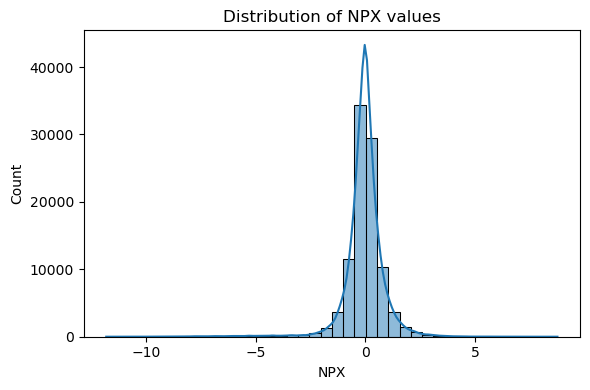

In [47]:
plt.figure(figsize=(6,4))
sns.histplot(olink_pass['NPX'], bins=40, kde=True)
plt.xlabel("NPX")
plt.ylabel("Count")
plt.title("Distribution of NPX values")
plt.tight_layout()
plt.show()

###### This boxplot show which samples are potentially outliers or if there is some batch effect (only if few of samples are not in norm)

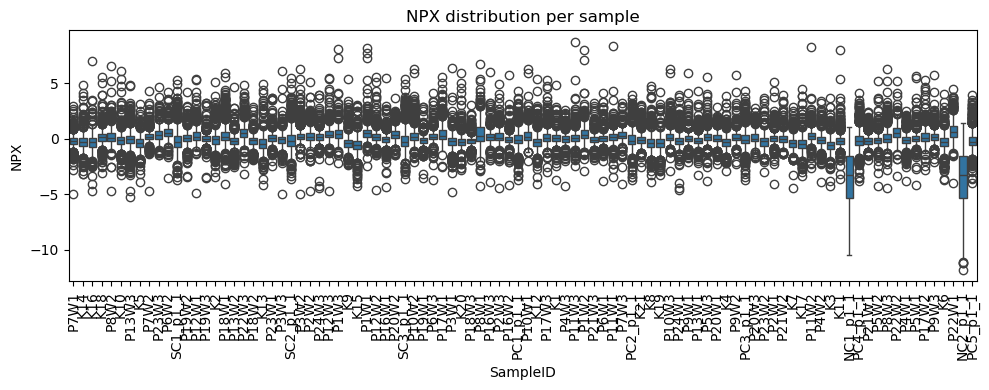

In [48]:
plt.figure(figsize=(10,4))
sns.boxplot(x='SampleID', y='NPX', data=olink_pass)
plt.xticks(rotation=90)
plt.title("NPX distribution per sample")
plt.tight_layout()
plt.show()

###### Every sample seem fine, NC1 and NC2 are negative controls so we predict their values to be lower, now let's see if normalization works:

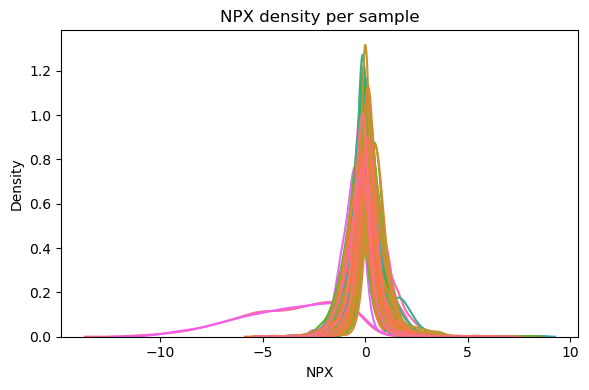

In [49]:
plt.figure(figsize=(6,4))
sns.kdeplot(
    data=olink_pass,
    x='NPX',
    hue='SampleID',
    common_norm=False,
    legend=False
)
plt.title("NPX density per sample")
plt.tight_layout()
plt.show()

In [50]:
olink_pass.groupby('SampleID')['NPX'].agg(['mean', 'std'])

,mean,std
SampleID,,
K1,0.096712,0.586367
K10,-0.101656,0.719089
K11,-0.146184,0.667938
K12,-0.323742,0.728006
K13,-0.451893,0.775077
...,...,...
PC4_p1_1,-0.122187,0.845059
PC5_p1_1,-0.193672,0.846628
SC1_p1_1,-0.171336,1.015400


###### Again, apart from negative control every density line covers so it's OK. Now for PCA and differential expression let's remove this controls from dataset:

In [51]:
olink_pass = olink_pass[~olink_pass['SampleType'].str.contains('CONTROL', na=False)]

olink_pass['SampleID'].unique().tolist()

['P7W1',
 'K14',
 'K16',
 'K18',
 'P8W2',
 'K10',
 'P13W3',
 'K5',
 'P7W2',
 'P23W3',
 'P6W2',
 'P19W2',
 'P12W1',
 'P19W3',
 'K2',
 'P18W1',
 'P13W2',
 'P22W3',
 'P18W2',
 'K13',
 'P23W1',
 'P3W3',
 'P3W2',
 'P2W2',
 'P24W3',
 'P12W3',
 'P1W3',
 'K9',
 'K15',
 'P1W1',
 'P12W2',
 'P16W1',
 'P20W2',
 'P10W2',
 'P19W1',
 'P6W3',
 'P17W1',
 'P3W1',
 'K20',
 'P18W3',
 'P8W1',
 'P16W3',
 'P2W3',
 'P16W2',
 'P10W1',
 'K12',
 'P17W3',
 'K1',
 'P4W3',
 'P11W3',
 'P1W2',
 'P21W3',
 'P6W1',
 'P11W1',
 'P7W3',
 'K21',
 'K8',
 'K19',
 'P10W3',
 'P24W1',
 'P9W1',
 'P13W1',
 'P5W3',
 'P20W1',
 'K4',
 'P9W2',
 'P20W3',
 'P23W2',
 'P2W1',
 'P21W2',
 'K7',
 'K17',
 'P11W2',
 'P4W2',
 'K3',
 'K11',
 'P21W1',
 'P5W2',
 'P8W3',
 'P22W2',
 'P4W1',
 'P5W1',
 'P17W2',
 'P9W3',
 'K6',
 'P22W1']

###### Pivot the table so we will generate PCA and heatmaps easier (protein x samples):

In [52]:
expr_mat = olink_pass.pivot_table(
    index='Assay',
    columns='SampleID',
    values='NPX'
)

###### Before the PCA, we must calculate z-score of protein expression, this will show us "which protein has the highest signal":

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
expr_z = pd.DataFrame(
    scaler.fit_transform(expr_mat.T).T,
    index=expr_mat.index,
    columns=expr_mat.columns
)

###### Finally we can do PCA:

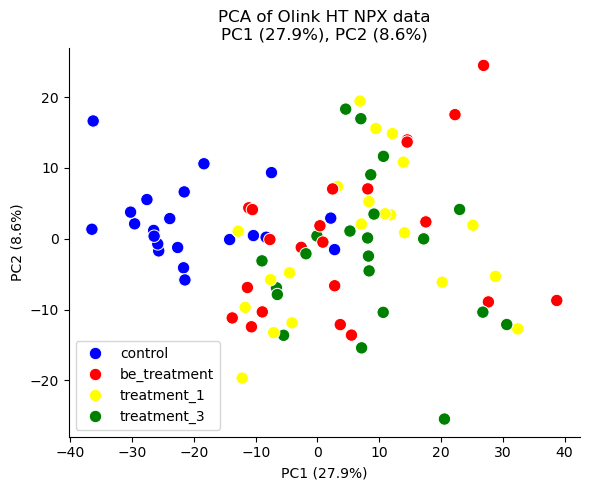

In [59]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(expr_z.T)

# DataFrame z wynikami PCA
pca_df = pd.DataFrame(
    pcs,
    columns=['PC1', 'PC2'],
    index=expr_z.columns
)

meta_df = (
    olink_pass[['SampleID', 'Group_Name1']]
    .drop_duplicates()
    .set_index('SampleID')
)


# dodanie informacji o grupie
pca_df = pca_df.join(meta_df)

# kolory ręcznie jak w R
palette = {
    'control': 'blue',
    'be_treatment': 'red',
    'treatment_1': 'yellow',
    'treatment_3': 'green'
}

# wykres PCA
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Group_Name1',
    palette=palette,
    s=80,       # odpowiada size = 3 w ggplot
    alpha=1     # w ggplot alpha=1
)
plt.title(
    f"PCA of Olink HT NPX data\nPC1 ({pca.explained_variance_ratio_[0]*100:.1f}%), "
    f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='')  # usuwa tytuł legendy
sns.despine()
plt.tight_layout()
plt.show()

###### We will take a closer look at the extremes of two main principal components:

In [64]:
pca_df.reset_index().sort_values('PC1')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].head(5)

,SampleID,PC1,PC2,Group_Name1
14,K3,-36.516542,1.341041,control
6,K15,-36.309736,16.636219,control
8,K17,-30.252134,3.758816,control
4,K13,-29.598095,2.110817,control
10,K19,-27.609622,5.538398,control


In [66]:
pca_df.reset_index().sort_values('PC1')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].tail(5)

,SampleID,PC1,PC2,Group_Name1
45,P1W1,27.661474,-8.921014,be_treatment
75,P6W2,28.807271,-5.319490,treatment_1
56,P22W3,30.628121,-12.117089,treatment_3
55,P22W2,32.412615,-12.733345,treatment_1
54,P22W1,38.727965,-8.720123,be_treatment


In [65]:
pca_df.reset_index().sort_values('PC2')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].head(5)

,SampleID,PC1,PC2,Group_Name1
59,P23W3,20.547248,-25.469624,treatment_3
58,P23W2,-12.194732,-19.683170,treatment_1
50,P20W3,7.141182,-15.413032,treatment_3
67,P3W3,-5.486066,-13.639552,treatment_3
57,P23W1,5.500286,-13.611975,be_treatment


In [67]:
pca_df.reset_index().sort_values('PC2')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].tail(5)

,SampleID,PC1,PC2,Group_Name1
82,P8W3,7.016024,16.958689,treatment_3
36,P17W1,22.255168,17.533137,be_treatment
38,P17W3,4.563778,18.311756,treatment_3
37,P17W2,6.879549,19.442753,treatment_1
80,P8W1,26.884143,24.487169,be_treatment


###### As we can observe there is no sample with outstanding high or low variation, we will not exclude any sample. Now let's move to differential analysis

In [73]:
group_map = {
    'control': 'Control',
    'be_treatment': 'Treatment',
    'treatment_1': 'Treatment',
    'treatment_3': 'Treatment'
}

olink_pass['Group_simple'] = olink_pass['Group_Name1'].map(group_map)
#olink_pass['Group_simple'].value_counts()

olink_long = (
    olink_pass[['Assay', 'SampleID', 'NPX', 'Group_simple']].dropna(subset=['Group_simple']) 
)

###### Now that we have two groups (control vs treatment) we cab actually make diff analysis:

In [75]:
results = []

for assay, df_a in olink_long.groupby('Assay'):
    ctrl = df_a.loc[df_a['Group_simple'] == 'Control', 'NPX']
    trt  = df_a.loc[df_a['Group_simple'] == 'Treatment', 'NPX']

    if len(ctrl) < 2 or len(trt) < 2:
        continue

    t_stat, p_val = ttest_ind(trt, ctrl, nan_policy='omit')

    results.append({
        'Assay': assay,
        'mean_Treatment': trt.mean(),
        'mean_Control': ctrl.mean(),
        'lfc': trt.mean() - ctrl.mean(),
        't_stat': t_stat,
        'p_value': p_val
    })

diff_results = pd.DataFrame(results)

diff_results['fdr'] = multipletests(
    diff_results['p_value'],
    method='fdr_bh'
)[1]

diff_results = diff_results.sort_values('fdr')

diff_results.head()

,Assay,mean_Treatment,mean_Control,lfc,t_stat,p_value,fdr
314,EDA2R,0.255216,-1.363359,1.618575,12.182957,2.944262e-20,3.038479e-17
301,DPY30,0.141529,-0.868658,1.010187,11.999968,6.636256e-20,3.424308e-17
459,IFI30,0.192247,-1.488408,1.680655,11.038136,5.016513e-18,1.725680e-15
452,HSPB6,0.161784,-0.829121,0.990905,10.459065,7.042832e-17,1.817051e-14
554,KLRF1,0.127361,-0.810486,0.937848,10.352553,1.147872e-16,2.369209e-14


###### Let's visualize diff_result matrix by volcano plot:

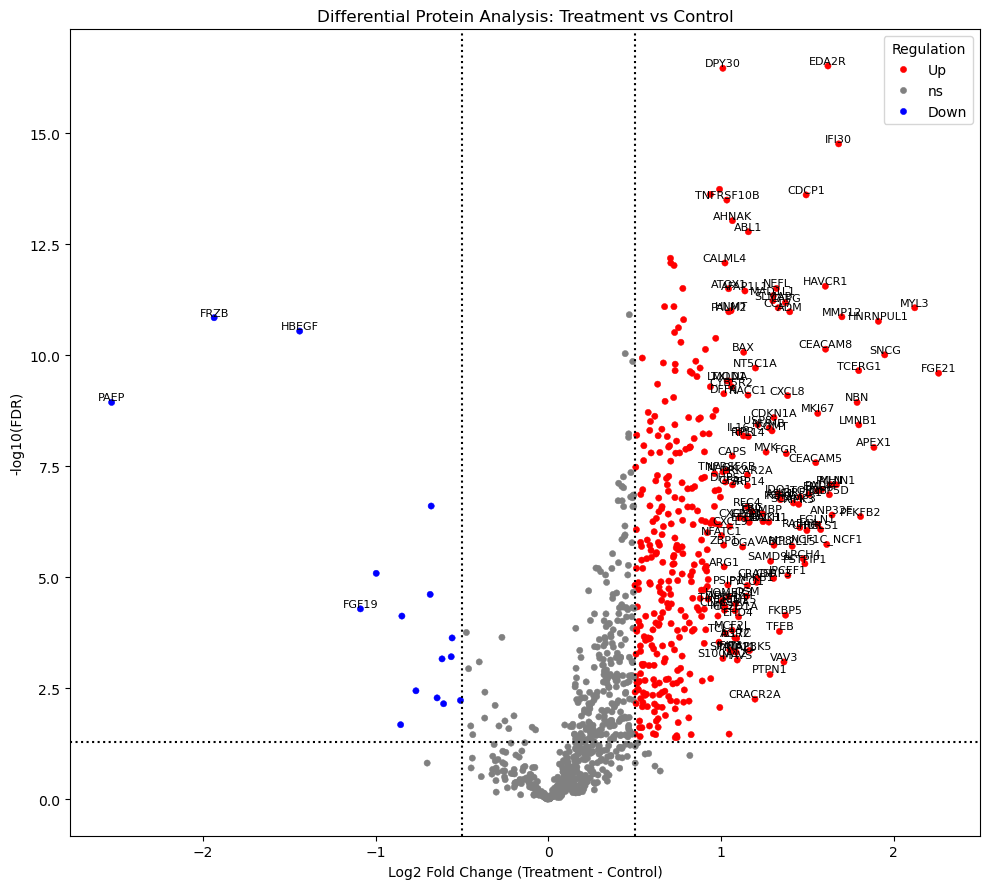

In [79]:
diff_results['neglog10_fdr'] = -np.log10(diff_results['fdr'])

diff_results['Regulation'] = np.where(
    (diff_results['fdr'] >= 0.05) | (diff_results['lfc'].abs() <= 0.5),
    'ns',
    np.where(diff_results['lfc'] > 0.5, 'Up', 'Down')
)

palette = {
    'Up': 'red',
    'Down': 'blue',
    'ns': 'grey'
}


plt.figure(figsize=(10,9))

sns.scatterplot(
    data=diff_results,
    x='lfc',
    y='neglog10_fdr',
    hue='Regulation',
    palette=palette,
    s=20,
    edgecolor=None
)


plt.axhline(-np.log10(0.05), linestyle='dotted', color='black')
plt.axvline(0.5, linestyle='dotted', color='black')
plt.axvline(-0.5, linestyle='dotted', color='black')

label_df = diff_results.query("fdr < 0.01 and abs(lfc) > 1")

for _, row in label_df.iterrows():
    plt.text(
        row['lfc'],
        row['neglog10_fdr'],
        row['Assay'],
        fontsize=8,
        ha='center',
        va='bottom'
    )


plt.title("Differential Protein Analysis: Treatment vs Control")
plt.xlabel("Log2 Fold Change (Treatment - Control)")
plt.ylabel("-log10(FDR)")
plt.legend(title="Regulation")
plt.tight_layout()
plt.show()

###### Summary with table for fdr < 0.05

In [80]:
reg_summary_fdr = (
    diff_results
    .assign(
        Regulation=lambda df: np.where(
            (df['fdr'] < 0.05) & (df['lfc'] > 0), 'Up',
            np.where(
                (df['fdr'] < 0.05) & (df['lfc'] < 0), 'Down',
                'ns'
            )
        )
    )
    .query("Regulation != 'ns'")
    .groupby('Regulation', as_index=False)
    .size()
    .rename(columns={'size': 'n_genes'})
    .sort_values('Regulation')
)

reg_summary_fdr

,Regulation,n_genes
0,Down,31
1,Up,638


###### and with |lfc| > 0.5

In [81]:
reg_summary_fdr_lfc = (
    diff_results
    .assign(
        Regulation=lambda df: np.where(
            (df['fdr'] < 0.05) & (df['lfc'] > 0.5), 'Up',
            np.where(
                (df['fdr'] < 0.05) & (df['lfc'] < -0.5), 'Down',
                'ns'
            )
        )
    )
    .query("Regulation != 'ns'")
    .groupby('Regulation', as_index=False)
    .size()
    .rename(columns={'size': 'n_genes'})
    .sort_values('Regulation')
)

reg_summary_fdr_lfc

,Regulation,n_genes
0,Down,16
1,Up,408


###### Lastly we will add heatmap with clustered samples and top most variable proteins

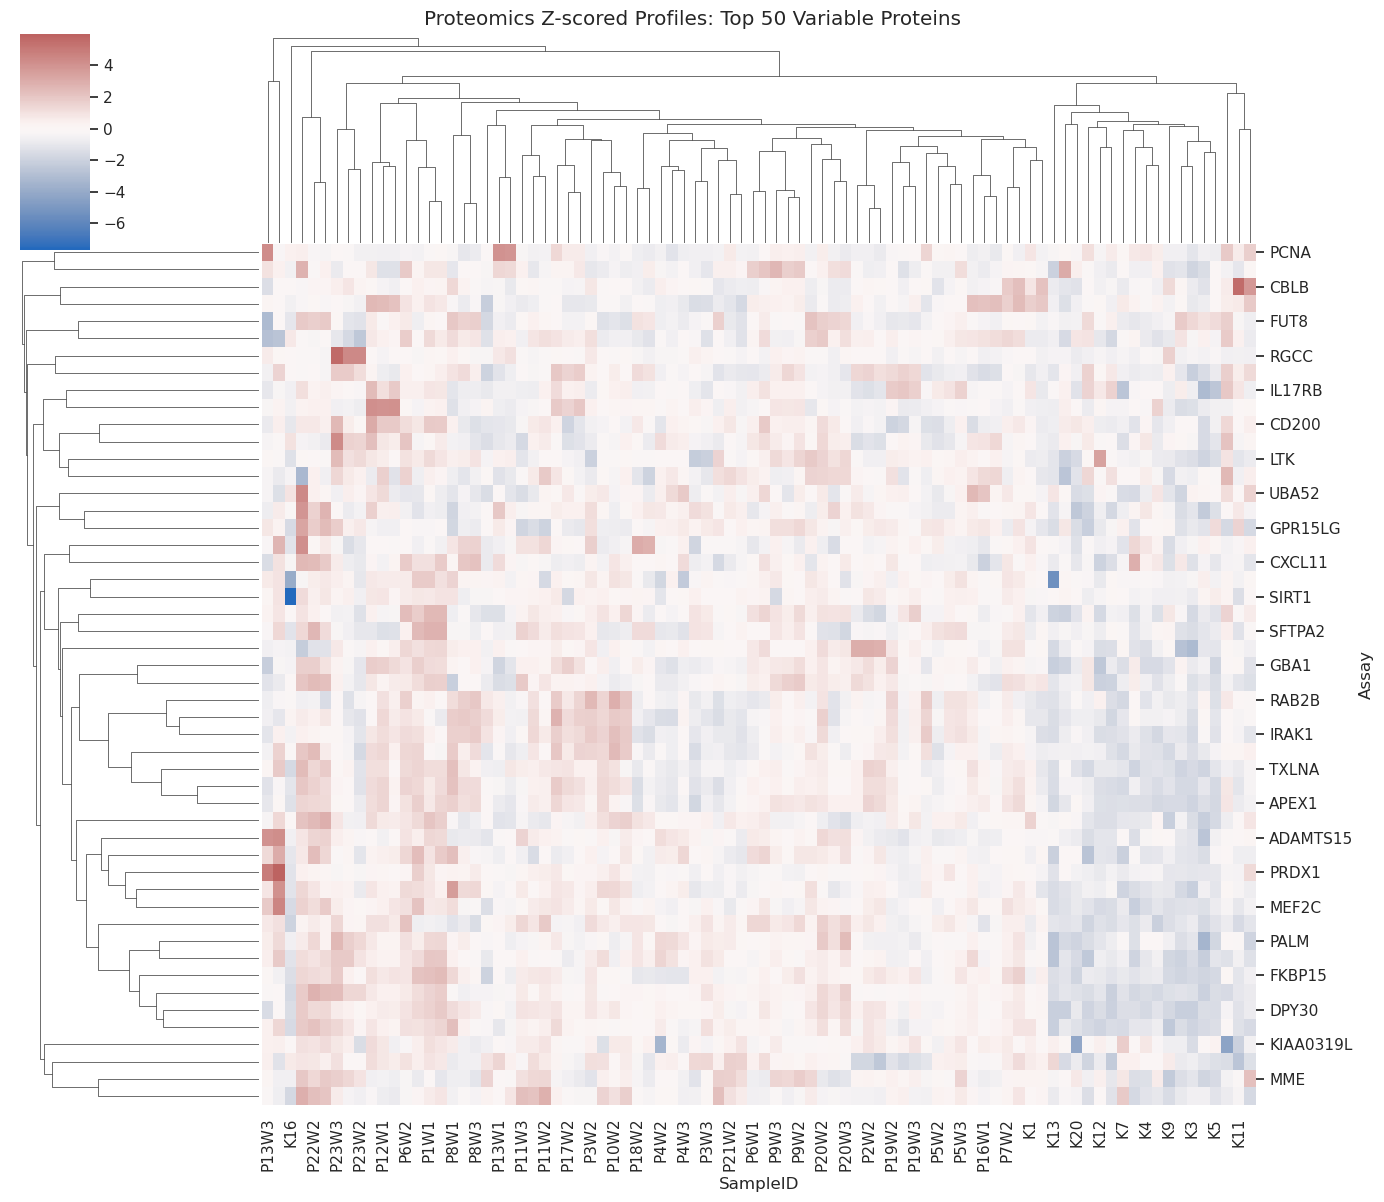

In [ ]:
heatmap_df = olink_pass.pivot(index='Assay', columns='SampleID', values='PCNormalizedNPX')

heatmap_z = pd.DataFrame(
    zscore(heatmap_df.values, axis=1, nan_policy='omit'),
    index=heatmap_df.index,
    columns=heatmap_df.columns
)

top_var = heatmap_z.var(axis=1).sort_values(ascending=False).head(50).index
heatmap_top = heatmap_z.loc[top_var]
sns.set(style="white")
g = sns.clustermap(
    heatmap_top,
    cmap='vlag',
    row_cluster=True,
    col_cluster=True,
    center=0,
    figsize=(14,12)
)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("Proteomics Z-scored Profiles: Top 50 Variable Proteins", y=1.00)
plt.show()